# Steady Wing Aerostructural Analysis

## Problem Setup

Imagine we have a flexible wing. We want to know how the wing will deform under aerodynamic loads. We also want to know how the aerodynamic loads will change due to the wing deformation. This is a coupled problem that needs to simultaneously solve an aerodynamic and structural problem.

The aerodynamic problem is solved using a vortex lattice method. The structural problem is solved using an Euler-Bernoulli beam model. The aerodynamic and structural problems are coupled through the aerodynamic loads and structural deflections.

One tricky part of this problem is that the aerodynamic and structural problems need to share information, and hence should either:
* Share the same underlying discretization ("mesh")
* Transfer information cleanly between different discretizations.

We will do the former, which generally makes life much easier.

Let's set up our problem. First, we define a function that will make a deformed wing for us:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np


def make_wing(
        span: float,
        ys_over_half_span: np.ndarray,
        chords: np.ndarray,
        twists: np.ndarray,
        offsets: np.ndarray = None,
        heave_displacements: np.ndarray = None,
        twist_displacements: np.ndarray = None,
        x_ref_over_chord: float = 0.33,
        airfoil: asb.Airfoil = asb.Airfoil("dae11"),
        color="black",
) -> asb.Wing:
    """
    Generates a wing based on a given set of per-cross-section characteristics.

    Args:

        span: Span of the wing [meters].

        ys_over_half_span: Array of the y-locations of each cross-section, normalized by half-span. Should be between 0 and 1.

        chords: Array of the chord lengths of each cross-section [meters].

        twists: Array of the twist angles of each cross-section [degrees].

        offsets: Array of the x-offsets of the leading edge of each cross-section [meters]. Defaults to -chords / 4, yielding an unswept quarter-chord.

        heave_displacements: Array of the vertical displacements of the shear center of each cross-section [meters]. Defaults to zero.

        twist_displacements: Array of the twist displacements of each cross-section [degrees], as measured about the shear center. Defaults to zero.

        x_ref_over_chord: The x-location of the shear center (i.e., torsion axis), normalized by the chord. Defaults to 0.33.

        airfoil: The airfoil to use for all cross-sections. Defaults to the DAE11.

    Returns:

        A Wing object.
    """
    if offsets is None:
        offsets = -chords / 4
    if heave_displacements is None:
        heave_displacements = np.zeros_like(ys_over_half_span)
    if twist_displacements is None:
        twist_displacements = np.zeros_like(ys_over_half_span)

    xsecs = []

    for i in range(len(ys_over_half_span)):
        xyz_le = np.array([
            -chords[i] * x_ref_over_chord,
            ys_over_half_span[i] * (span / 2),
            0
        ])
        xyz_le = np.rotation_matrix_3D(
            angle=np.radians(twists[i] + twist_displacements[i]),
            axis="y"
        ) @ xyz_le
        xyz_le += np.array([
            offsets[i] + chords[i] * x_ref_over_chord,
            0,
            heave_displacements[i]
        ])

        xsecs.append(
            asb.WingXSec(
                xyz_le=xyz_le,
                chord=chords[i],
                twist=twists[i] + twist_displacements[i],
                airfoil=airfoil,
            )
        )

    return asb.Wing(
        symmetric=True,
        xsecs=xsecs,
        color=color,
    )

We can test this out by generating an example wing. This can be drawn in both its jig shape (black) and an example deformed shape (teal).

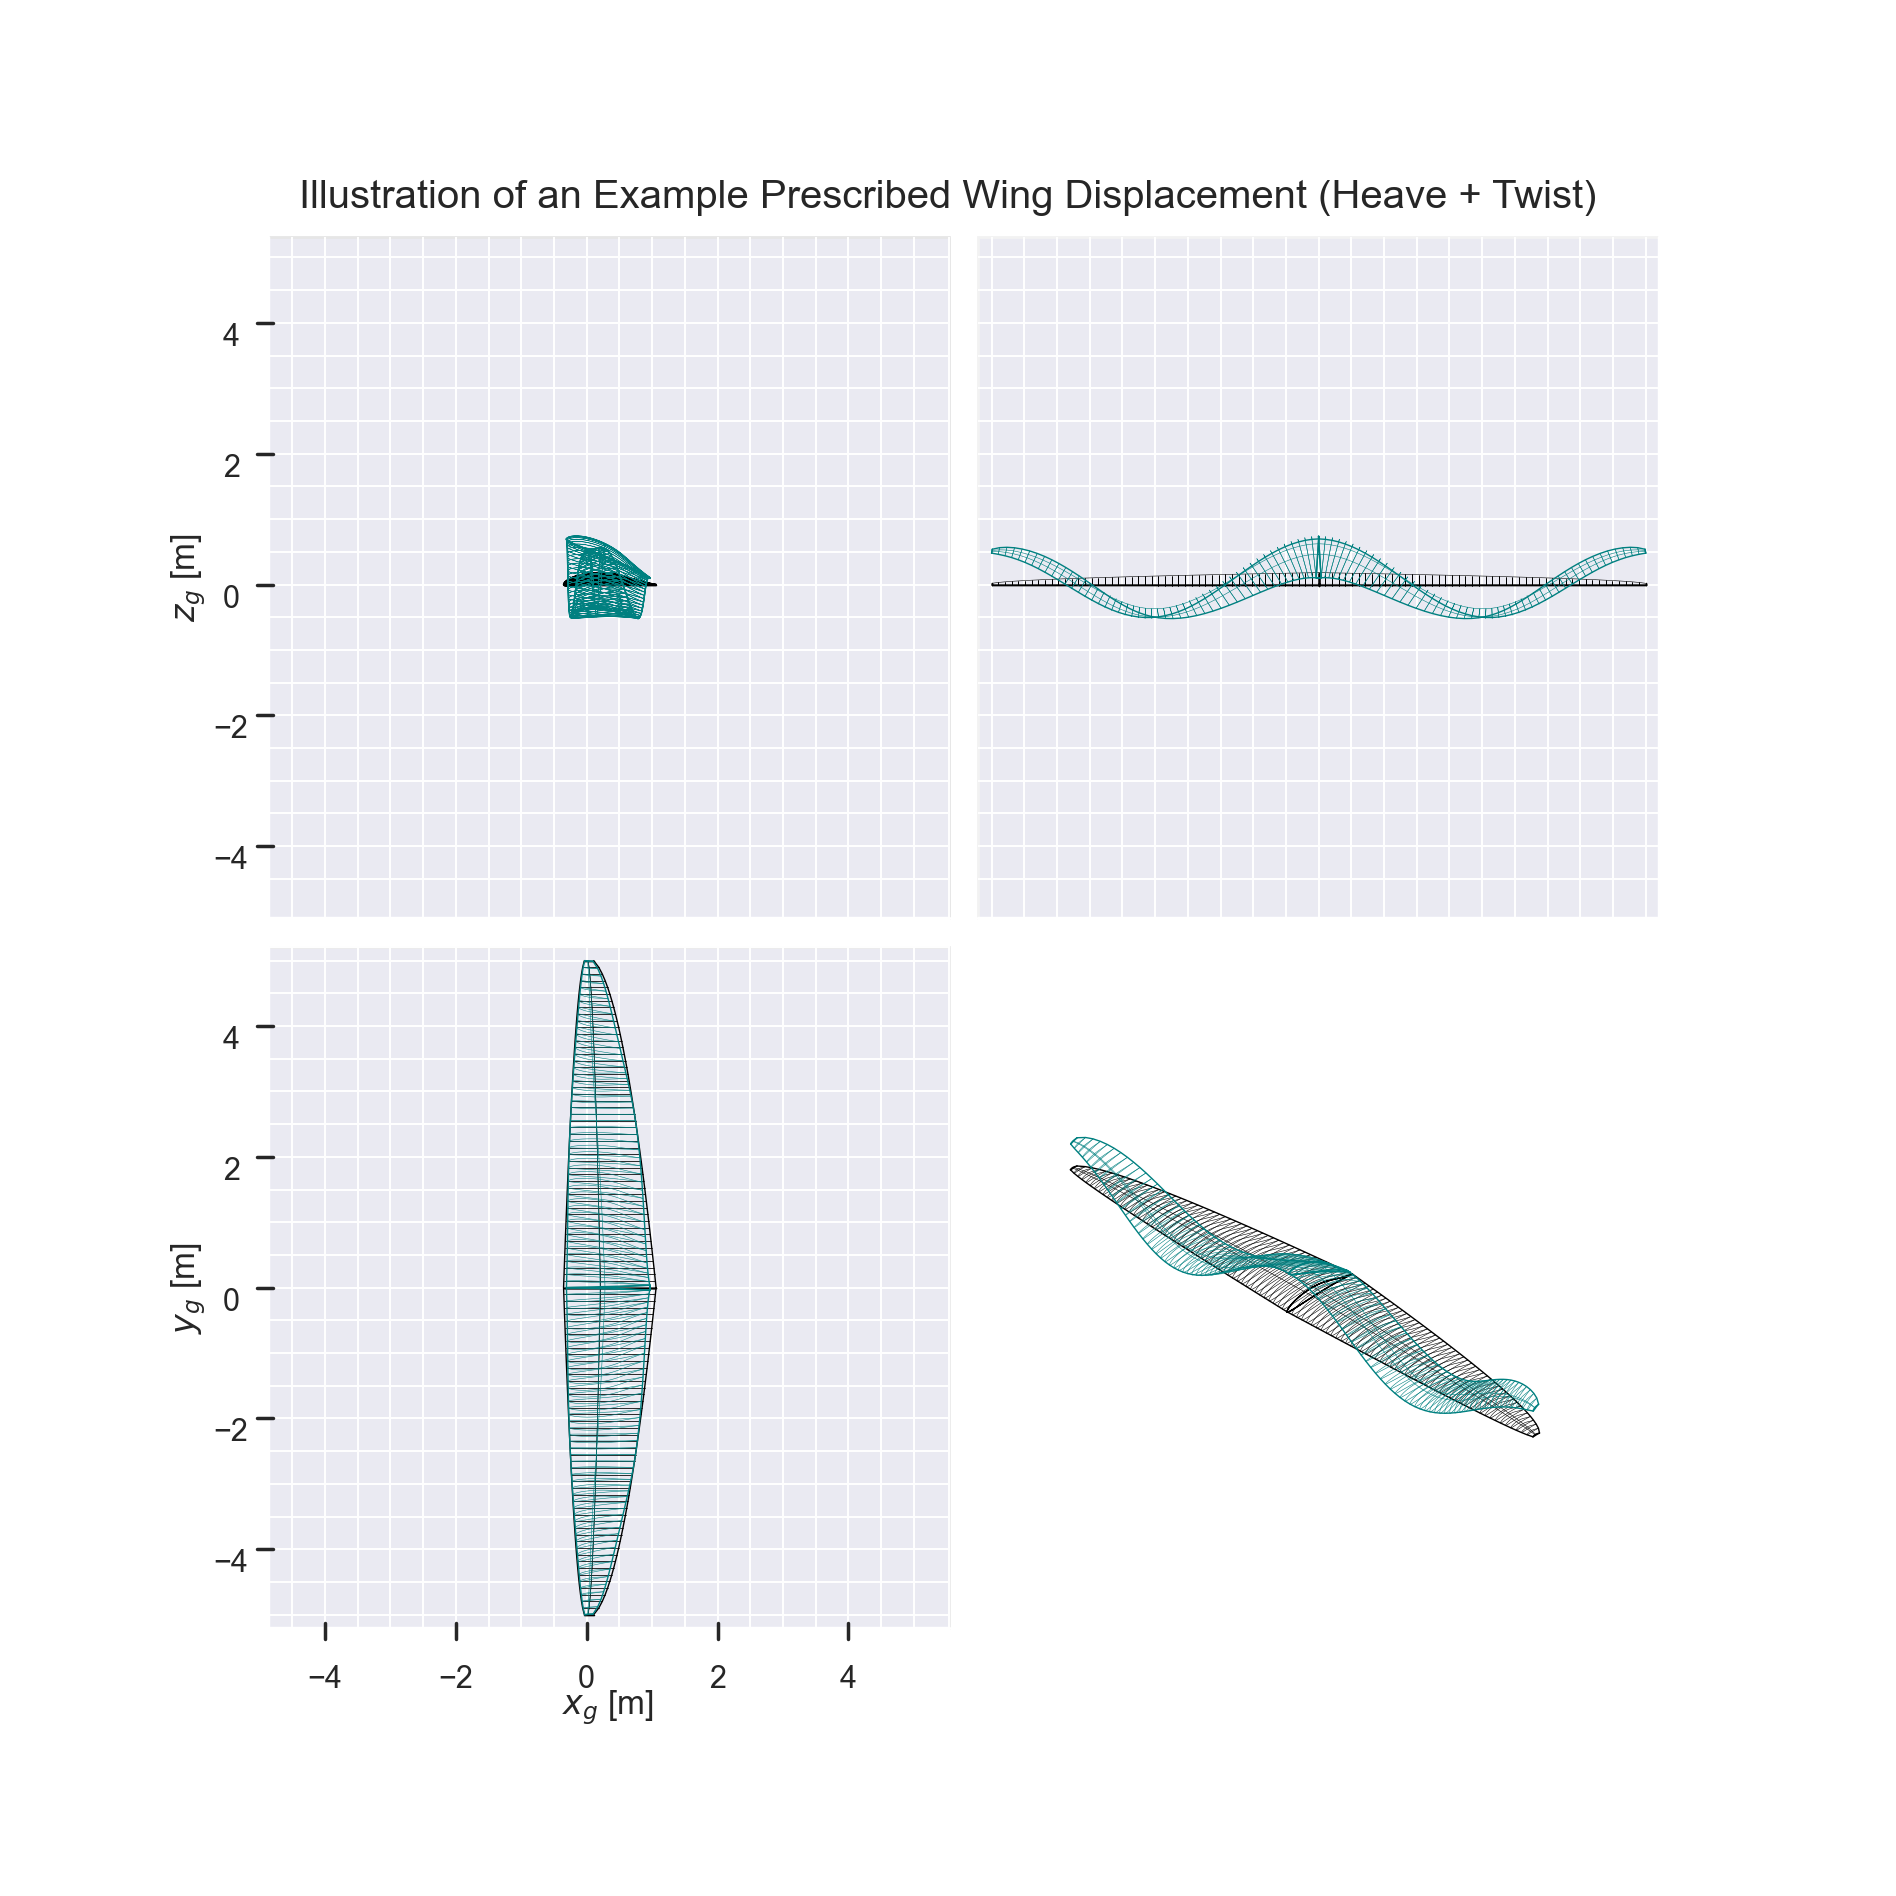

In [2]:
span = 10
ys_over_half_span = np.linspace(0, 1)
chords = np.linspace(2, 0.02) ** 0.5
twists = np.linspace(0, 0)
offsets = None

wing = make_wing(
    span=span,
    ys_over_half_span=ys_over_half_span,
    chords=chords,
    twists=twists,
    offsets=offsets,
    color="black",
)

wing_deformed = make_wing(
    span=span,
    ys_over_half_span=ys_over_half_span,
    chords=chords,
    twists=twists,
    offsets=offsets,
    heave_displacements=0.5 * np.cos(np.linspace(0, 2 * np.pi)),
    twist_displacements=25 * np.cos(np.linspace(0, np.pi)),
    color="teal",
)

import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

preset_view_angles = np.array([
    ["XZ", "-YZ"],
    ["XY", "left_isometric"]
], dtype="O")

fig, axs = p.figure3d(
    nrows=preset_view_angles.shape[0],
    ncols=preset_view_angles.shape[1],
    figsize=(8, 8),
)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        ax = axs[i, j]
        preset_view = preset_view_angles[i, j]

        for w in [wing, wing_deformed]:
            w.draw_wireframe(
                ax=ax,
                set_axis_visibility=False if 'isometric' in preset_view else None,
                show=False,
            )

        p.set_preset_3d_view_angle(preset_view)

        xres = np.diff(ax.get_xticks())[0]
        yres = np.diff(ax.get_yticks())[0]
        zres = np.diff(ax.get_zticks())[0]

        p.set_ticks(
            xres, xres / 4,
            yres, yres / 4,
            zres, zres / 4,
        )

        ax.xaxis.set_tick_params(color='white', which='minor')
        ax.yaxis.set_tick_params(color='white', which='minor')
        ax.zaxis.set_tick_params(color='white', which='minor')

        if preset_view == 'XY' or preset_view == '-XY':
            ax.set_zticks([])
        if preset_view == 'XZ' or preset_view == '-XZ':
            ax.set_yticks([])
        if preset_view == 'YZ' or preset_view == '-YZ':
            ax.set_xticks([])

axs[1, 0].set_xlabel("$x_g$ [m]")
axs[1, 0].set_ylabel("$y_g$ [m]")
axs[0, 0].set_zlabel("$z_g$ [m]")
axs[0, 0].set_xticklabels([])
axs[0, 1].set_yticklabels([])
axs[0, 1].set_zticklabels([])

plt.subplots_adjust(
    left=-0.08,
    right=1.08,
    bottom=-0.08,
    top=1.08,
    wspace=-0.38,
    hspace=-0.38,
)
plt.suptitle("Illustration of an Example Prescribed Wing Displacement (Heave + Twist)")

p.show_plot(tight_layout=False)


Now, let's link the aerostructures together using a real problem. Note the prescribed $EI$ and $GJ$ values, which are proportional to the local chord cubed (corresponding to a tube spar with constant wall thickness and constant chord-normalized diameter - just as an example).

In [3]:
import aerosandbox as asb
import aerosandbox.numpy as np

### Gather known-a-priori problem info
ys = ys_over_half_span * (span / 2)
EI = chords ** 3 * 20
GJ = chords ** 3 * 1

### Specify the unknowns in the context of an optimization problem
opti = asb.Opti()

u = opti.variable(
    init_guess=np.linspace(0, 1.5) ** 2,
)

theta = opti.variable(
    init_guess=np.linspace(0, -15),
)

### Make the geometry
wing = make_wing(
    span=span,
    ys_over_half_span=ys_over_half_span,
    chords=chords,
    twists=twists,
    offsets=offsets,
    heave_displacements=u,
    twist_displacements=theta,
)

### Do the aero analysis
vlm = asb.VortexLatticeMethod(
    airplane=asb.Airplane(
        name="Aerostructures Test",
        xyz_ref=[0, 0, 0],
        wings=[wing],
    ),
    op_point=asb.OperatingPoint(
        velocity=10,
        alpha=5,
    ),
    chordwise_resolution=1,
    spanwise_resolution=1,
)
aero = vlm.run()

### Do the heave structures analysis
du = opti.derivative_of(
    variable=u, with_respect_to=ys,
    derivative_init_guess=np.zeros_like(u),
)
ddu = opti.derivative_of(
    variable=du, with_respect_to=ys,
    derivative_init_guess=np.zeros_like(u),
)

opti.subject_to([  # Add the boundary conditions
    u[0] == 0,
    du[0] == 0,
    ddu[-1] == 0,
])

### Link the aerodynamic and heave analyses together
opti.constrain_derivative(
    variable=EI * ddu, with_respect_to=ys,
    derivative=np.concatenate([
        -vlm.forces_geometry[:len(ys) - 1, 2],
        0
    ]),
)

### Do the torsion structures analysis
dtheta = opti.derivative_of(
    variable=theta, with_respect_to=ys,
    derivative_init_guess=np.zeros_like(theta),
)

opti.subject_to([  # Add the boundary conditions
    theta[0] == 0,
    dtheta[-1] == 0,
])

opti.constrain_derivative(
    variable=GJ * dtheta, with_respect_to=ys,
    derivative=np.concatenate([
        -vlm.moments_geometry[:len(ys) - 1, 1],
        0
    ]),
)

### Solve the system
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    10589
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      250
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      250
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.06e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

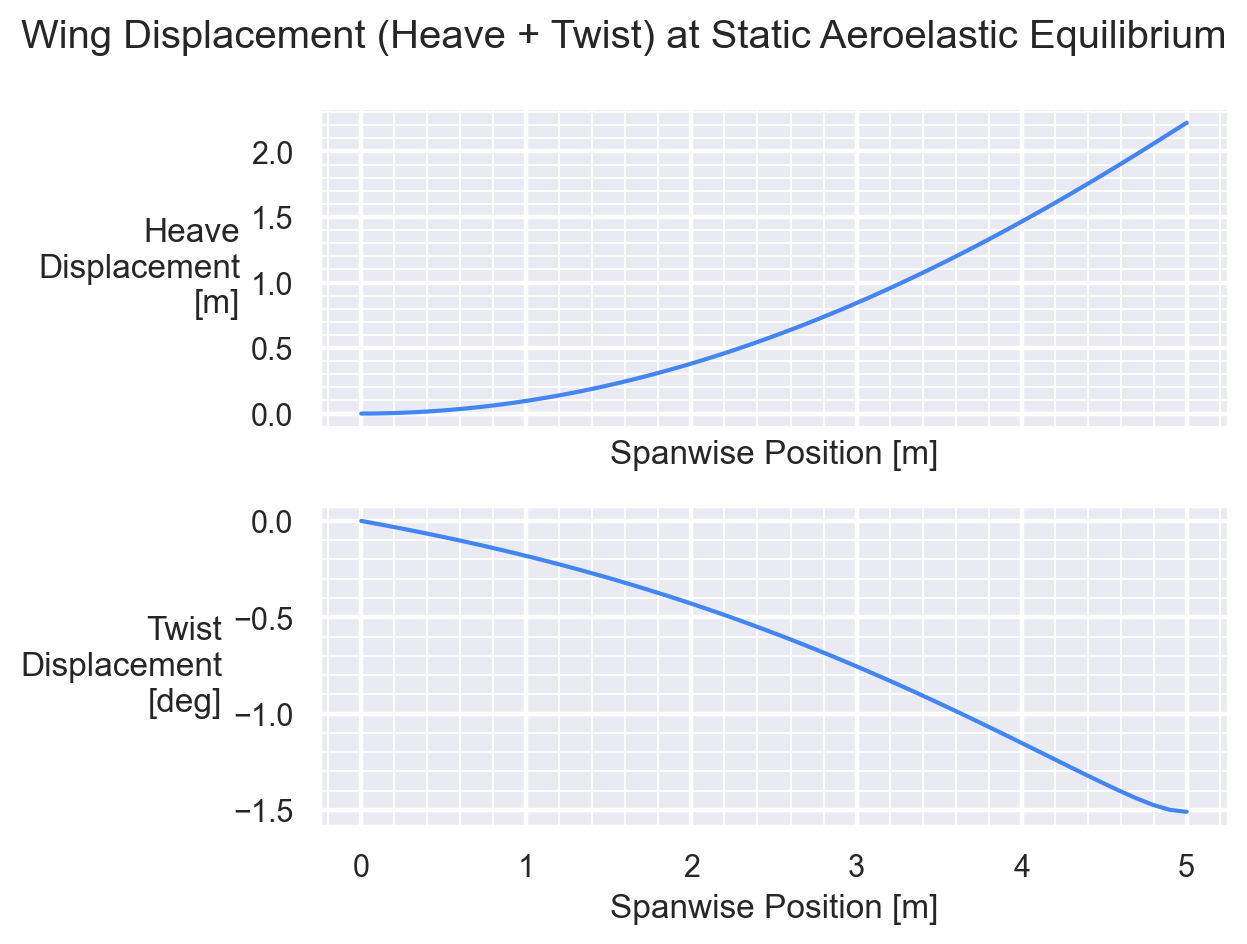

ValueError: `axs` must be a 2D array of axes; instead, it is: [<Axes: xlabel='Spanwise Position [m]', ylabel='Heave\nDisplacement\n[m]'>
 <Axes: xlabel='Spanwise Position [m]', ylabel='Twist\nDisplacement\n[deg]'>].

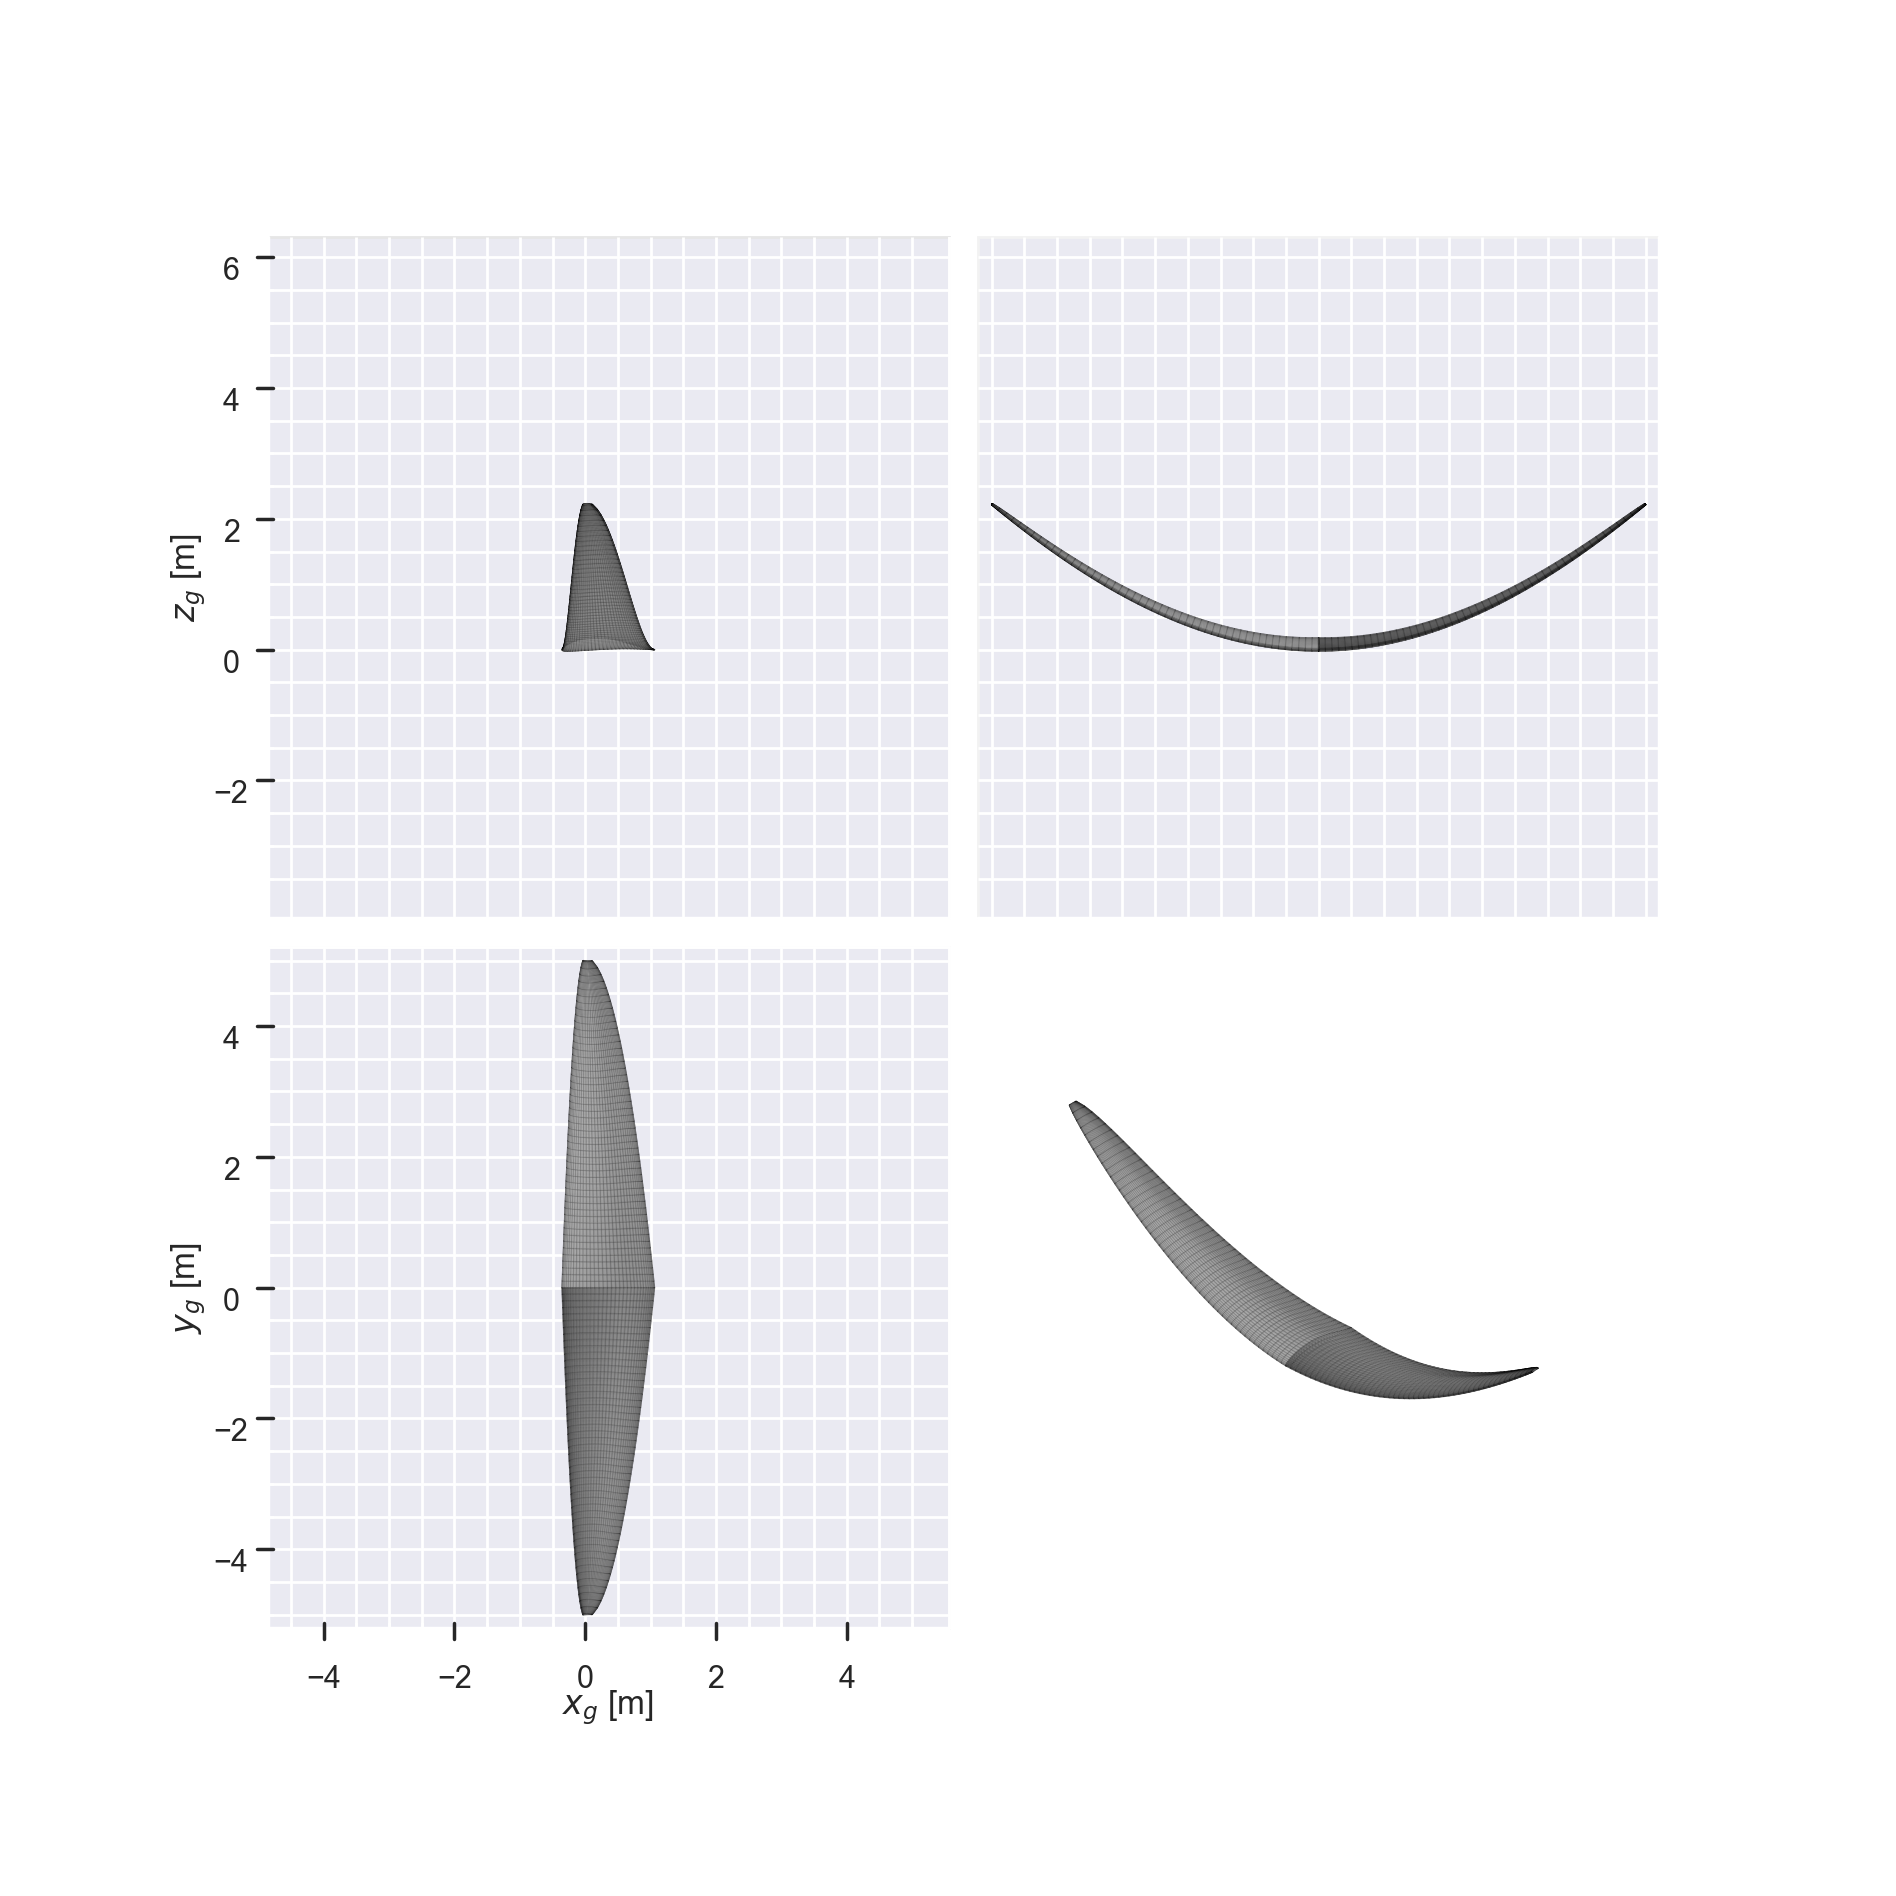

In [4]:
### Display output
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(ys, sol(u), label="Heave")
ax[0].set_ylabel("Heave Displacement [m]")
ax[1].plot(ys, sol(theta), label="Twist")
ax[1].set_ylabel("Twist Displacement [deg]")
p.show_plot(
    title="Wing Displacement (Heave + Twist) at Static Aeroelastic Equilibrium",
    xlabel="Spanwise Position [m]",
    legend=False,
)

wing_deformed = make_wing(
    span=span,
    ys_over_half_span=ys_over_half_span,
    chords=chords,
    twists=twists,
    offsets=offsets,
    heave_displacements=sol(u),
    twist_displacements=sol(theta),
)
wing_deformed.color = "C0"
wing_deformed.draw_three_view(show=False)
make_wing(
    span=span,
    ys_over_half_span=ys_over_half_span,
    chords=chords,
    twists=twists,
    offsets=offsets,
    # heave_displacements=sol(u),
    # twist_displacements=sol(theta),
).draw_three_view(fig=fig, style="wireframe")
plt.suptitle("Wing Displacement (Heave + Twist) at Static Aeroelastic Equilibrium")

This gives an example of the relative ease of coupling together various AeroSandbox codes. In this case, we coupled together the Vortex Lattice Method with an Euler-Bernoulli beam model as well as a beam torsion model, all in less than 100 lines of code.

Note that this workbook currently only models structural torque due to aerodynamic sectional pitching moment, and not due to aerodynamic sectional lift at a moment arm due to wing sweep. Hence, it will underpredict the washout of high-aspect-ratio, highly-swept, lifting wings. Adding this in would be very straightforward (just modify the torsion-torque constraint relation appropriately), and this tutorial gives the skeleton of what this would look like. If you'd like to add this effect in, please feel free to submit a pull request!